<a href="https://colab.research.google.com/github/LLT9798/Twitter-Demography-Research-Project/blob/master/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
%matplotlib notebook
from PIL import Image
from sklearn.utils import shuffle



#pre-processing
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer



#modeling
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier




#CV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from numpy import array
from sklearn.model_selection import KFold

In [0]:
df = pd.read_csv('791531.csv', encoding='latin-1')
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

### Intro

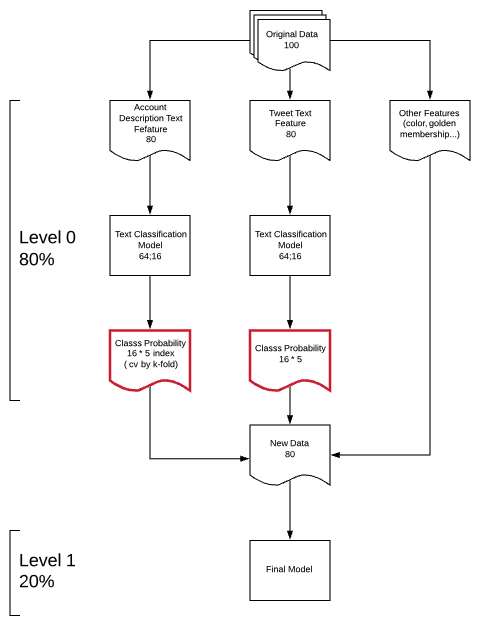

In [0]:
Image.open('screenshot3.png')

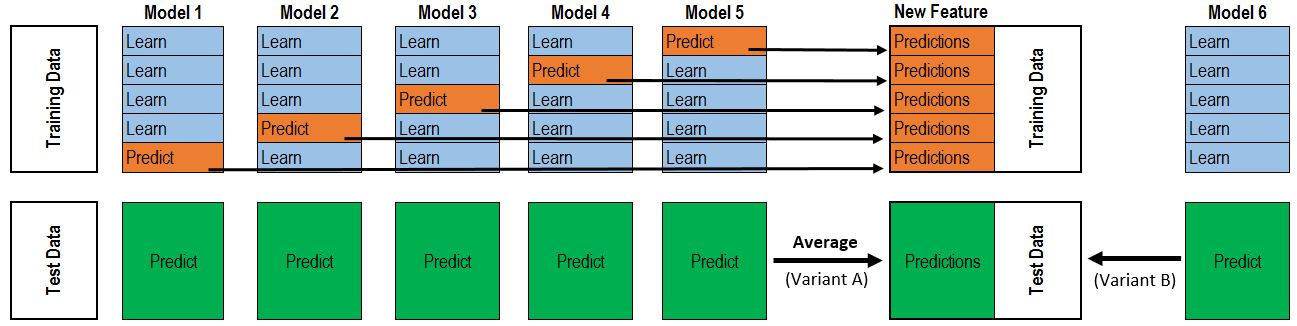

In [0]:
Image.open('screenshot4.png')

### A. Cleaning

### Crop

In [0]:
df = df[['text', 'description', 'sidebar_color', 'gender:confidence', 'gender']]
#the model's main purpose is detecting gender, so we didn't pick 'location' feature
df.dropna(inplace = True)
df.drop(df[(df['gender'] == 'unknown') | 
           (df['gender'] == 'brand')].index, inplace = True)
df.drop(df[df['gender:confidence'] != 1].index, inplace = True)


In [0]:
df.shape

(8766, 5)

In [0]:
df.head(1)

,text,description,sidebar_color,gender:confidence,gender
0,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.,FFFFFF,1.0,male


In [0]:
#two funcitons for normalization
def doc_features(doc):
    #HTML
    pattern = r"http\S+"
    documents = re.sub(pattern, " ", doc)
    
    #'-' letters
    documents = re.sub("[^a-zA-Z]"," ", doc)
    
    #To lower case
    words = documents.lower().split()
    
    #Stop words (nltk)
    stop = set(stopwords.words("english"))
    words = [w for w in words if not w in stop]
    
    #Stemmer & Return
    features = []
    stemmer = english_stemmer
    for word in words:
        features.append(stemmer.stem(word))
        
    return(features)
    
def text_cleaner(text):
    clean_text = []
    for i in text:
        clean_text.append(' '.join(doc_features(i)))
    
    return clean_text

In [0]:
df['text'] = text_cleaner(df['text']);
df['description'] = text_cleaner(df['description']);

In [0]:
del df['gender:confidence']

In [0]:
df

,text,description,sidebar_color,gender
0,robbi e respond critic win eddi edward worldti...,sing rhythm,FFFFFF,male
1,felt like friend live stori https co arng yhno...,author novel fill famili drama romanc,C0DEED,male
3,hi jordanspieth look url use ifttt typic see a...,mobil guy er shazam googl kleiner perkin yahoo...,C0DEED,male
4,watch neighbour sky catch neighb xxx xxx,ricki wilson best frontman kaiser chief best b...,0,female
5,ive seen peopl train lamp chair tvs etc https ...,know,0,female
...,...,...,...,...
20044,need ride home practic rain hard asf,love,C0DEED,female
20045,lookupondeath fine drink tea love,rp,C0DEED,female
20046,greg hardi good player get face dez bryant lea...,whatev like problem chargern foreverroy edm mu...,0,male
20047,miss peopl still never want see,teambarcelona look lost follow follow heart br...,C0DEED,male


### Map

In [0]:
df['gender'] = df['gender'].map({ 'male':1, 'female':0})

In [0]:
df.groupby('gender').count()[['sidebar_color']]

,sidebar_color
gender,
0,4616
1,4150


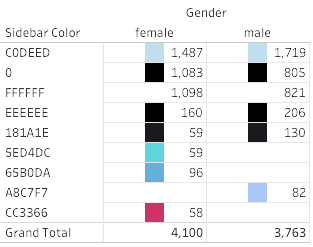

In [0]:
Image.open('screenshot1.png')
#This chart only display "sidebar_color" counts > 50;
#Except sidebar_color = 0, all the color display with real RGB

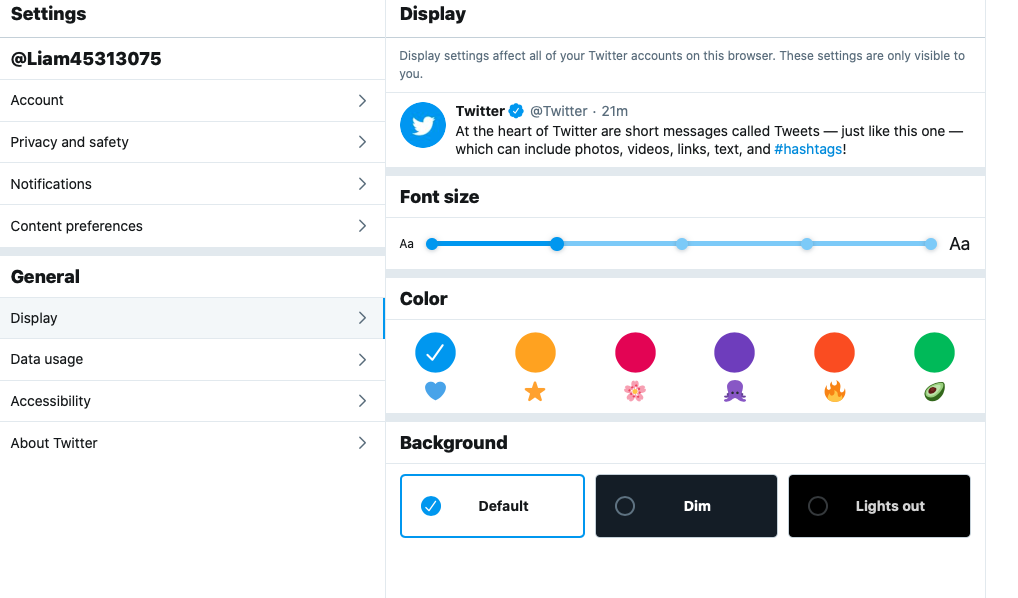

In [0]:
#By this chart, we hard to tell how sidebar color correlates to gender
#Moreover, current Twitter seems not allowing customized sidebar color 
#only 6 theme colors
Image.open('screenshot2.png')

### B. Preprocessing

In [0]:
#shuffle df and split train_test for level0 modeling
df = shuffle(df)
df.reset_index(drop=True, inplace= True)
df.head(5)

,text,description,sidebar_color,gender
0,redbrick corri letsbi avenu,angri news junki hate tori libdem labour frust...,D3D2CF,0
1,mccann one faith howl like fuck everi time don...,last teenag idol,FFFFFF,1
2,charlott dtv help spread word app scope find h...,surfer travel love life adventur life,0,1
3,free premium spotifi best premium spotifi,go path may lead go instead path leav trail,C0DEED,0
4,swear god spend life schedul attend meet,futur realli disclos find peopl sing,DBE9ED,0


In [0]:
len(df)*0.8

7012.8

#we will utilize df1 for level 0 model training and df2 for level 1 testing

df1 = df[['text','description','gender']].loc[:7010]
df2 = df[['text','description','gender']].loc[7011:]

In [0]:
df_level0 = df[['text', 'description', 'gender']]

In [0]:
df_level0_train = df_level0[['text','description','gender']].loc[:7010]
df_level0_test = df_level0[['text','description','gender']].loc[7011:]

In [0]:
print (df_level0_train.shape, df_level0_test.shape)

(7011, 3) (1755, 3)


### C. Level 0 Modeling

In [0]:
# Feed df_level0

In [0]:
def text_vec_convert(X_train, X_test, X_oof_test):
    #apply countvectorizer, deafult n-gram (1,1)
    vectorizer = CountVectorizer(ngram_range = (1,1))
    
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_oof_test = vectorizer.transform(X_oof_test)
    
    return X_train, X_test, X_oof_test


def MNB_modeling(X_train, y_train):
    clf = MultinomialNB(alpha = 1)
    clf.fit(X_train, y_train)
    return clf

def get_train_prediction(X, y, X_oof_test, df_train):
    '''
    Wrape up and process K-Fold validation, text_vector_convert, and MNB_modeling
    
    Output: Dataframe of train prob prediction & oof prob prediction (3 rows)
    '''
    
    #set up K-Fold loop & get index
    
    kf = KFold(n_splits = 10, shuffle = True)
    scores = []
    kfold_output_df = pd.DataFrame({'index':[], 'prob_female':[], 'prob_male':[] })
    oof_pred_df = pd.DataFrame({'kfold_batch':[],'index':[], 'prob_female':[], 'prob_male':[] })
    kfold_batch = 1
    
    for train_index, test_index in kf.split(df_train):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        print ('len(df):', len(df_train))
        print ('len(X_train):', len(X_train))
        print ('len(X_test):', len(X_test))
        
        #vector convert
        X_oof_test_temp = X_oof_test
        X_train, X_test, X_oof_test_temp = text_vec_convert(X_train, X_test, X_oof_test_temp)
          
        #feed in MNB
        clf = MNB_modeling(X_train, y_train)
        
        #get accuracy scores
        score = clf.score(X_test, y_test)
        scores.append(score)
        
        #get prediction and match with index;
        
        kfold_pred = clf.predict_proba(X_test)
        kfold_temp = pd.DataFrame({'index':j, 'prob_female':i[0], 'prob_male':i[1] } 
                               for i, j in zip(kfold_pred, test_index))
        kfold_output_df = kfold_output_df.append(kfold_temp, sort= True)
        
        
        print ('score for each iteration:', score)
        
        #utilize clf for oof_test set
        oof_pred = clf.predict_proba(X_oof_test_temp)
        oof_temp = pd.DataFrame({'kfold_batch':kfold_batch,'index':j, 'prob_female':i[0], 'prob_male':i[1] } 
                               for i, j in zip(oof_pred, range(X_oof_test.shape[0])))
        oof_pred_df = oof_pred_df.append(oof_temp, sort= True)
        kfold_batch += 1
        
    print ('-----------------------')
    print ('avg accuracy:', np.mean(scores))
    print ('-----------------------')
    
    output = {'dataframe': [kfold_pred, oof_pred_df]}
    return kfold_output_df, oof_pred_df

In [0]:
kfold_text, oof_text = get_train_prediction(df_level0_train['text'], df_level0_train['gender']
                                   , df_level0_test['text'], df_level0_train)

len(df): 7011
len(X_train): 6309
len(X_test): 702
score for each iteration: 0.6068376068376068
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.637660485021398
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6162624821683309
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6291012838801712
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.5977175463623395
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6105563480741797
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6134094151212554
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.630527817403709
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6162624821683309
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6119828815977175
-----------------------
avg accuracy: 0.617031834863

In [0]:
kfold_desc, oof_desc = get_train_prediction(df_level0_train['description'], df_level0_train['gender']
                                   , df_level0_test['description'], df_level0_train)

len(df): 7011
len(X_train): 6309
len(X_test): 702
score for each iteration: 0.6652421652421653
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.68188302425107
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.68188302425107
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6718972895863052
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6533523537803139
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6776034236804565
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.68188302425107
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6904422253922967
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6576319543509273
len(df): 7011
len(X_train): 6310
len(X_test): 701
score for each iteration: 0.6904422253922967
-----------------------
avg accuracy: 0.6752260710177972

### Check & Clean K-Fold prediction

In [0]:
kfold_text.shape

(7011, 3)

In [0]:
#check duplicated data
print (kfold_text['index'].duplicated().sum())
print (kfold_desc['index'].duplicated().sum())

0
0


In [0]:
kfold_text = kfold_text.sort_values(by=['index'])
kfold_text.head(5)

,index,prob_female,prob_male
0,0.0,0.010798,0.989202
0,1.0,0.410832,0.589168
0,2.0,0.403875,0.596125
0,3.0,0.854775,0.145225
1,4.0,0.829010,0.170990


In [0]:
kfold_desc = kfold_desc.sort_values(by=['index'])
kfold_desc.head(5)

,index,prob_female,prob_male
0,0.0,0.367546,0.632454
0,1.0,0.659995,0.340005
0,2.0,0.481990,0.518010
1,3.0,0.170695,0.829305
0,4.0,0.263439,0.736561


In [0]:
kfold_train_df = pd.merge(left= kfold_text, right= kfold_desc, left_on='index', right_on='index')
kfold_train_df.head(2) 

,index,prob_female_x,prob_male_x,prob_female_y,prob_male_y
0,0.0,0.010798,0.989202,0.367546,0.632454
1,1.0,0.410832,0.589168,0.659995,0.340005


In [0]:
kfold_train_df = kfold_train_df[['prob_male_x', 'prob_male_y']]
kfold_train_df.rename(columns = {'prob_male_x': 'p_male_text', 'prob_male_y': 'p_male_desc'}, inplace= True)

In [0]:
kfold_train_df

,p_male_text,p_male_desc
0,0.989202,0.632454
1,0.589168,0.340005
2,0.596125,0.518010
3,0.145225,0.829305
4,0.170990,0.736561
...,...,...
7006,0.929608,0.539225
7007,0.608805,0.997872
7008,0.466555,0.396030
7009,0.504872,0.097362


### Check & Clean Test Prediction

In [0]:
1755*5

8775

In [0]:
oof_desc.shape

(17550, 4)

In [0]:
def avg_oof_scores(rows, df):
    gb = df.groupby('index') 
    df_group = [gb.get_group(x) for x in gb.groups]
    
    avg_scores = []
    for i in range(rows):
        avg_score = df_group[i]['prob_male'].mean()
        avg_scores.append(avg_score)
    return avg_scores

In [0]:
oof_text_avg = avg_oof_scores(df_level0_test.shape[0], oof_text)
oof_desc_avg = avg_oof_scores(df_level0_test.shape[0], oof_desc)

In [0]:
len(oof_desc_avg)

1755

In [0]:
oof_df = pd.DataFrame({'p_male_text':i, 'p_male_desc':j } 
                      for i, j in zip(oof_text_avg, oof_desc_avg))

In [0]:
oof_df

,p_male_text,p_male_desc
0,0.574513,0.269314
1,0.018958,0.130972
2,0.257815,0.000225
3,0.063286,0.132245
4,0.634236,0.111601
...,...,...
1750,0.864252,0.311657
1751,0.431378,0.026798
1752,0.449762,0.225112
1753,0.969634,0.821259


### Merge Level 0 output to Level1 df

In [0]:
df_level1 = kfold_train_df.append(oof_df, sort= False)

In [0]:
df_level1.iloc[7009]

p_male_text    0.504872
p_male_desc    0.097362
Name: 7009, dtype: float64

In [0]:
df_level1.reset_index(drop= True, inplace= True)

In [0]:
df_level1.head(1)

,p_male_text,p_male_desc
0,0.989202,0.632454


In [0]:
df['gender'] = df['gender'].astype(str)

In [0]:
df_level1['gender'] = df['gender']

In [0]:
df_level1

,p_male_text,p_male_desc,gender
0,0.989202,0.632454,0
1,0.589168,0.340005,1
2,0.596125,0.518010,1
3,0.145225,0.829305,0
4,0.170990,0.736561,0
...,...,...,...
8761,0.864252,0.311657,0
8762,0.431378,0.026798,0
8763,0.449762,0.225112,1
8764,0.969634,0.821259,1


### D. Level 1 Modeling

In [0]:
X = df_level1[['p_male_text', 'p_male_desc']]
y = df_level1['gender']

In [0]:
def simple_lv1(X, y):
    data, eval_data, target, eval_target = train_test_split(X, y, test_size=0.20,random_state=100)
    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        ('ridge',RidgeClassifier()),
        ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        ('random_forest',RandomForestClassifier()),
        ('svc',LinearSVC()),
        ('deep_nn',MLPClassifier()),
        ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        #('MNB', MultinomialNB(alpha = 1))
    ]
    
    scores=[]
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(data,target)
        score = pipe.score(eval_data, eval_target)
        scores.append(score)
        
    return (scores)

In [0]:
m1_scores = simple_lv1(X, y)

/Users/Lee_Lu/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
m1_scores

[0.6733181299885975,
 0.6733181299885975,
 0.6727480045610034,
 0.6744583808437856,
 0.6425313568985177,
 0.6727480045610034,
 0.6784492588369442,
 0.6351197263397947]

## Method 2 

In [0]:
#Image.open('screenshot5.png')

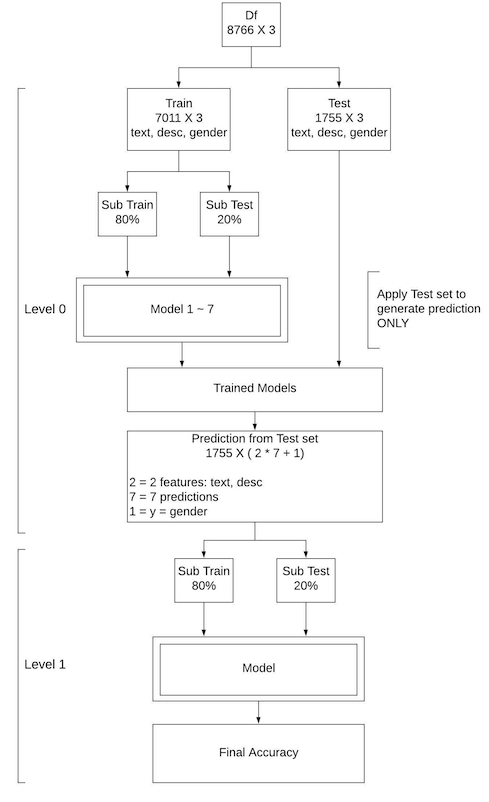

In [0]:
#the chart of data flow
Image.open('screenshot6.png')

### A. Pre-processing

In [0]:
m2_df_level0 = df[['text', 'description', 'gender']]

In [0]:
m2_df_level0.head(2)

,text,description,gender
0,redbrick corri letsbi avenu,angri news junki hate tori libdem labour frust...,0
1,mccann one faith howl like fuck everi time don...,last teenag idol,1


In [0]:
m2_df_level0_train = m2_df_level0[['text','description','gender']].loc[:7010]
m2_df_level0_test = m2_df_level0[['text','description','gender']].loc[7011:]

In [0]:
print (m2_df_level0_train.shape, m2_df_level0_test.shape)

(7011, 3) (1755, 3)


### B. Level 0 Modeling

In [0]:
m2_df_level0_train

,text,description,gender
0,redbrick corri letsbi avenu,angri news junki hate tori libdem labour frustrat lack anger coalit polici,0
1,mccann one faith howl like fuck everi time dont win cunt clear young,last teenag idol,1
2,charlott dtv help spread word app scope find https co rzgztq fjt,surfer travel love life adventur life,1
3,free premium spotifi best premium spotifi,go path may lead go instead path leav trail,0
4,swear god spend life schedul attend meet,futur realli disclos find peopl sing,0
...,...,...,...
7006,bookmonster haha well work sinc esther drew face hehe thank,illustr doodler mum two http co nvzs pkc,0
7007,tomorrow littl cousin,r e,0
7008,watch video otra show sweden almost half year ago,want make happiest world harri style,0
7009,impud rabiu kwakwanso fulani brother ffk written femi fani kayod read https co jk vez,promot,1


In [0]:
m2_df_level0_test

,text,description,gender
7011,build transform workbench desk storag unit lot space need https co qa ztz gfr lifehack,muslim pakistani born luv food peac luver hate ego futur web develop instangram hussainal comput scienc student gamer,1
7012,epow mag masquerad sea aboard liberti yacht saturday octob st ocean dr https co af vexzgo,love south florida look forward assist travel airportshuttl cruisetransf assist,0
7013,shoot moon even miss land among star les brown,anger gonna make progress achiev stay cool achiev great,0
7014,new novel social media link updat new blurb https co ifkylf byu,author progress readi east coast philadelphia love nors mytholog love mytholog period,0
7015,time season lsuvsbama geauxtig purpleandgold https co p buy,ollu track field redefin great,1
...,...,...,...
8761,nba best moment nba histori michael jordan scotti pippen denni rodman set new record,gone bonker afraid let tell secret best peopl,0
8762,pg esam best air move reliabl charact good air game get juggl air way much,white girl phenomenon guid thephenomenale youtub vlogger train super smash brother addict colleg senior,0
8763,pull race card,year old limit drink weekend build k weekday colgat crest cloth necessari neither tact,0
8764,friend bring best meanwhil school make critic bitchi,hello kyle tweet like warm chees nintendo id kit man psn kyrosin write music safenotesmus,1


In [0]:
def text_vec_convert2(X_train, X_test):
    vectorizer = CountVectorizer(ngram_range = (1,1))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test

In [0]:
def m2_lv0_modeling(X_train, y_train, X_column):
    
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train,
                                                                        test_size=0.50, random_state=100)
    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        #('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        #('random_forest',RandomForestClassifier()),
        #('deep_nn',MLPClassifier()),
        #('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        #('MNB', MultinomialNB(alpha = 1))
        ]
    
    pipes=[]
    model_name = []
    pred_sub_df = pd.DataFrame({'clf_name':[], 'prob_male':[]})
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_sub_train,y_sub_train)
        
        print(model[0], 'accuracy:', pipe.score(X_sub_test, y_sub_test))
        pred_sub = pipe.predict_proba(X_sub_test)
        pred_sub_df_temp = pd.DataFrame({'clf_name': X_column + '_' + model[0], 
                                         'prob_male':pred_sub[m, 1]} for m in range(len(pred_sub)))
        pred_sub_df = pred_sub_df.append(pred_sub_df_temp, sort= False)
        
        pipes.append(pipe)
        model_name.append(model[0])
     
    #return trained classfiers
    return pipes, model_name, pred_sub_df, y_sub_test


In [0]:
def m2_lv0_wrap(X_train, X_test, y_train):
    
    #take column name
    X_column = X_train.name
    
    #text vectorize
    X_train, X_test = text_vec_convert2(X_train, X_test)
    
    #modeling & get clf
    clfs, clf_names, pred_sub_df, y_sub_test = m2_lv0_modeling(X_train, y_train, X_column)
    
    #apply X_test to clf for prediction
    prediction_df = pd.DataFrame({'clf_name':[], 'prob_male':[]})
    for i , j in zip(clfs, clf_names):
        pred = i.predict_proba(X_test)
        prediction_df_temp = pd.DataFrame({'clf_name': X_column + '_' + j,
                                           'prob_male':pred[m, 1] } for m in range(len(pred)))
        prediction_df = prediction_df.append(prediction_df_temp, sort= False)
    #pivot prediction output
    prediction_df = prediction_df.pivot(index= None, columns= 'clf_name', values= 'prob_male')
    
    
    return prediction_df, pred_sub_df, y_sub_test
        
    

In [0]:
# y_test remains secret to clfs
m2_prediction_text, m2_subpred_text, y_sub_test = m2_lv0_wrap(m2_df_level0_train['text'], 
                                                                     m2_df_level0_test['text'],
                                                                     m2_df_level0_train['gender'])

m2_prediction_desc, m2_subpred_desc, y_sub_test = m2_lv0_wrap(m2_df_level0_train['description'], 
                                                                     m2_df_level0_test['description'],
                                                                     m2_df_level0_train['gender'])

logistic accuracy: 0.5707358813462635
lasso accuracy: 0.5636052481460354
logistic accuracy: 0.6648602395892755
lasso accuracy: 0.6565887050770108


### P(male) df form Level0 model

In [0]:
m2_df_level0_test['gender'].reset_index(drop= True, inplace= True)

In [0]:
m2_df_level1 = pd.concat([m2_prediction_text, m2_prediction_desc, m2_df_level0_test['gender']], axis= 1)
pd.set_option('display.max_colwidth', -1)
m2_df_level1.shape

(1755, 5)

In [0]:
m2_subpred_text = m2_subpred_text.pivot(index= None, columns= 'clf_name', values= 'prob_male')
m2_subpred_desc = m2_subpred_desc.pivot(index= None, columns= 'clf_name', values= 'prob_male')

In [0]:
y_sub_test.reset_index(drop= True, inplace= True)
m2_subpred_df = pd.concat([m2_subpred_text, m2_subpred_desc, y_sub_test], axis= 1)
pd.set_option('display.max_colwidth', -1)
m2_subpred_df.shape

(3506, 5)

In [0]:
m2_df_level1 = pd.concat([m2_df_level1, m2_subpred_df], axis= 0)
m2_df_level1.reset_index(drop= True, inplace= True)
m2_df_level1

,text_lasso,text_logistic,description_lasso,description_logistic,gender
0,0.536844,0.692763,0.898682,0.846054,1
1,0.494820,0.521837,0.302507,0.218245,0
2,0.641107,0.680520,0.728730,0.560892,0
3,0.674806,0.598773,0.481155,0.380695,0
4,0.493602,0.418539,0.431147,0.561172,1
...,...,...,...,...,...
5256,0.493602,0.543281,0.297651,0.258580,1
5257,0.714538,0.696907,0.400745,0.353105,1
5258,0.504696,0.629273,0.834285,0.849560,1
5259,0.274410,0.140785,0.575394,0.890815,0


In [0]:
m2_df_level1.index.duplicated().sum()

0

In [0]:
1755+3506

5261

In [0]:
#maybe do vector conver out of loop

In [0]:
pred_sub_df = pred_sub_df.pivot(index= None, columns= 'clf_name', values= ['prob_male', 'gender'])

NameError: name 'pred_sub_df' is not defined

### C. Level 1 Modeling

In [0]:
m2_df_level1.columns

Index(['lasso', 'logistic', 'lasso', 'logistic', 'gender'], dtype='object')

In [0]:
m2_X = m2_df_level1[['MNB', 'deep_nn', 'elasticnet', 'knn', 'lasso', 'logistic','random_forest']]
m2_y = m2_df_level1['gender']

m2_X_val = 
m2_y_val =

SyntaxError: invalid syntax (<ipython-input-139-224e637b0930>, line 4)

In [0]:
m2_X.shape

NameError: name 'm2_X' is not defined

In [0]:
m2_scores = simple_lv1(m2_X, m2_y)
m2_scores

NameError: name 'simple_lv1' is not defined

## Method 2 - revision

In [0]:
m2_df_level0['text']

0                             redbrick corri letsbi avenu
1       mccann one faith howl like fuck everi time don...
2       charlott dtv help spread word app scope find h...
3               free premium spotifi best premium spotifi
4                swear god spend life schedul attend meet
                              ...                        
8761    nba best moment nba histori michael jordan sco...
8762    pg esam best air move reliabl charact good air...
8763                                       pull race card
8764    friend bring best meanwhil school make critic ...
8765    aphmau pic defin mcd fangirl fanboy mcd shippe...
Name: text, Length: 8766, dtype: object

In [0]:
def m2_outer_loop(X, y, df):
    
        
    pred_df_inner = pd.DataFrame({'index':[]})
    pred_df_hideout = pd.DataFrame({'index':[], 'clf_name':[], 'prob_male':[]})
    
    kf = KFold(n_splits = 2, shuffle = False)
    k = 1


    for train_index, hideout_index in kf.split(X):
        X_train, X_hideout = X.iloc[train_index], X.iloc[hideout_index]
        y_train, y_hideout = y.iloc[train_index], y.iloc[hideout_index]
        print(train_index[0], train_index[-1], len(train_index))
        print ('-----------', 'Fold Loop%r'%k, '----------')
        print ('Train len:', len(X_train))
        print ('Hideout len:', len(X_hideout))
        
        vectorizer = CountVectorizer(ngram_range = (1,1))
        X_train = vectorizer.fit_transform(X_train)
        X_hideout = vectorizer.transform(X_hideout)
        
        #Train and get predictions from weak learners
        pred_df_inner_temp, pred_df_hideout_temp = m2_inner_loop(X_train, y_train, 
                                                                 X_hideout, hideout_index, k)
        
        pred_df_inner = pred_df_inner.append(pred_df_inner_temp, sort= False)
        pred_df_hideout = pred_df_hideout.append(pred_df_hideout_temp, sort= False)
        
        k+=1
        
    return pred_df_inner, pred_df_hideout

In [0]:
def m2_inner_loop(X_train, y_train, X_hideout, hideout_index, k):
     
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train,
                                                                        test_size=0.50, random_state=42)
    
    print ('Sub_train len(50%):', X_sub_train.shape[0])
    print ('Sub_test len(50%):', X_sub_test.shape[0])

    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        #('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        #('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        #('random_forest',RandomForestClassifier()),
        #('deep_nn',MLPClassifier()),
        #('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        #('MNB', MultinomialNB(alpha = 1))
        ]
    
    pred_df_inner = pd.DataFrame({'index':[], 'clf_name':[], 'k_fold':[], 'prob_male':[]})
    pred_df_hideout = pd.DataFrame({'index':[], 'clf_name':[], 'prob_male':[]})
    
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_sub_train,y_sub_train)
        print(model[0],'test acc score:',pipe.score(X_sub_test, y_sub_test))
        
        #inner loop prediction
        #50% of Train
        pred_inner = pipe.predict_proba(X_sub_test)
      
        pred_inner_df_temp = pd.DataFrame({'index':y_sub_test.index[m], 'clf_name': model[0], 'k_fold':k,
                                         'prob_male':pred_inner[m, 1]} for m in range(X_sub_test.shape[0]))
        pred_df_inner = pred_df_inner.append(pred_inner_df_temp, sort= True)
        
        #full set of Test
        pred_hideout = pipe.predict_proba(X_hideout)                                
        pred_hideout_df_temp = pd.DataFrame({'index':hideout_index[m], 'clf_name': model[0],
                                             'prob_male':pred_hideout[m, 1]} for m in range(X_hideout.shape[0]))
        
        pred_df_hideout = pred_df_hideout.append(pred_hideout_df_temp, sort= True)
        
        
    return pred_df_inner, pred_df_hideout

In [0]:
def m2_lv0_wrap_2(X, y, df):
    
    #get predictions
    pred_df_inner, pred_df_hideout = m2_outer_loop(X, y, df)
    print ('-----------------------------')
    print ('output Train prediction:', pred_df_inner.shape)
    print ('output Hideout prediction:', pred_df_hideout.shape)

    #pivot prediction output
    #pred_df = pred_df.pivot(index= None, columns= 'clf_name', values= 'prob_male')
    return pred_df_inner, pred_df_hideout

In [0]:
#convert text feature
m2_lv1_df_train_text, m2_lv1_df_hideout_text = m2_lv0_wrap_2(m2_df_level0['text'], m2_df_level0['gender'], 
                                                             m2_df_level0);

4383 8765 4383
----------- Fold Loop1 ----------
Train len: 4383
Hideout len: 4383
Sub_train len(50%): 2191
Sub_test len(50%): 2192
logistic test acc score: 0.5688868613138686
0 4382 4383
----------- Fold Loop2 ----------
Train len: 4383
Hideout len: 4383
Sub_train len(50%): 2191
Sub_test len(50%): 2192
logistic test acc score: 0.5506386861313869
-----------------------------
output Train prediction: (4384, 4)
output Hideout prediction: (8766, 3)


In [0]:
#convert desc feature
m2_lv1_df_train_desc, m2_lv1_df_hideout_desc = m2_lv0_wrap_2(m2_df_level0['description'], m2_df_level0['gender'],
                                                             m2_df_level0);

4383 8765 4383
----------- Fold Loop1 ----------
Train len: 4383
Hideout len: 4383
Sub_train len(50%): 2191
Sub_test len(50%): 2192
logistic test acc score: 0.6395985401459854
0 4382 4383
----------- Fold Loop2 ----------
Train len: 4383
Hideout len: 4383
Sub_train len(50%): 2191
Sub_test len(50%): 2192
logistic test acc score: 0.6459854014598541
-----------------------------
output Train prediction: (4384, 4)
output Hideout prediction: (8766, 3)


### Attach y to outputs

In [0]:
#text
m2_lv1_df_hideout_text = m2_lv1_df_hideout_text.merge(m2_df_level0['gender'], left_on='index', right_index=True)
m2_lv1_df_train_text = m2_lv1_df_train_text.merge(m2_df_level0['gender'], left_on='index', right_index=True)
m2_lv1_df_hideout_text.reset_index(drop=True);
m2_lv1_df_train_text.reset_index(drop=True);

#desc
m2_lv1_df_hideout_desc = m2_lv1_df_hideout_desc.merge(m2_df_level0['gender'], left_on='index', right_index=True)
m2_lv1_df_train_desc = m2_lv1_df_train_desc.merge(m2_df_level0['gender'], left_on='index', right_index=True)
m2_lv1_df_hideout_desc.reset_index(drop=True);
m2_lv1_df_train_desc.reset_index(drop=True);

### Merge hideout set for lv1 model validation

In [0]:
m2_lv1_df_hideout_text.rename(columns = {'prob_male':'text_pmale'}, inplace = True)
m2_lv1_df_hideout_desc.rename(columns = {'prob_male':'desc_pmale'}, inplace = True)

In [0]:
m2_lv1_df_hideout = pd.merge(m2_lv1_df_hideout_text, m2_lv1_df_hideout_desc, on= ['index','clf_name', 'gender'])
m2_lv1_df_hideout

,index,clf_name,text_pmale,gender,desc_pmale
0,0.0,logistic,0.714413,0,0.784011
1,0.0,lasso,0.469003,0,0.901113
2,0.0,elasticnet,0.812517,0,0.922287
3,0.0,random_forest,0.700000,0,0.800000
4,0.0,deep_nn,0.999024,0,0.999878
...,...,...,...,...,...
61357,8765.0,elasticnet,0.579031,0,0.335345
61358,8765.0,random_forest,0.700000,0,0.278805
61359,8765.0,deep_nn,0.347238,0,0.263948
61360,8765.0,knn,0.609036,0,0.200000


In [0]:
(61362/7)

8766.0

### Merge train set for lv1 model training

In [0]:
m2_lv1_df_train_text.rename(columns = {'prob_male':'text_pmale'}, inplace = True)
m2_lv1_df_train_desc.rename(columns = {'prob_male':'desc_pmale'}, inplace = True)

In [0]:
m2_lv1_df_train = pd.merge(m2_lv1_df_train_text, m2_lv1_df_train_desc, 
                           on= ['index', 'k_fold','clf_name','gender'])

### Double check data consistency

In [0]:
m2_lv1_df_train_text[m2_lv1_df_train_text['index']==8624]

,index,clf_name,k_fold,text_pmale,gender
2916,8624.0,logistic,1.0,0.545183,0
2916,8624.0,lasso,1.0,0.515595,0
2916,8624.0,elasticnet,1.0,0.624078,0
2916,8624.0,random_forest,1.0,0.300000,0
2916,8624.0,deep_nn,1.0,0.483894,0
...,...,...,...,...,...
2916,8624.0,elasticnet,9.0,0.436044,0
2916,8624.0,random_forest,9.0,0.500000,0
2916,8624.0,deep_nn,9.0,0.002354,0
2916,8624.0,knn,9.0,0.602652,0


In [0]:
print (m2_lv1_df_train_text['index'].value_counts().min())
print (m2_lv1_df_train_text['index'].value_counts().max())

7
63


In [0]:
63/9

7.0

In [0]:
m2_lv1_df_train_desc[m2_lv1_df_train_desc['index'] == 8624]

,index,clf_name,k_fold,desc_pmale,gender
2916,8624.0,logistic,1.0,0.373507,0
2916,8624.0,lasso,1.0,0.391984,0
2916,8624.0,elasticnet,1.0,0.340226,0
2916,8624.0,random_forest,1.0,0.200000,0
2916,8624.0,deep_nn,1.0,0.449429,0
...,...,...,...,...,...
2916,8624.0,elasticnet,9.0,0.353524,0
2916,8624.0,random_forest,9.0,0.227632,0
2916,8624.0,deep_nn,9.0,0.420598,0
2916,8624.0,knn,9.0,0.200000,0


In [0]:
m2_lv1_df_train[m2_lv1_df_train['index'] == 8624]

,index,clf_name,k_fold,text_pmale,gender,desc_pmale
138691,8624.0,logistic,1.0,0.545183,0,0.373507
138692,8624.0,lasso,1.0,0.515595,0,0.391984
138693,8624.0,elasticnet,1.0,0.624078,0,0.340226
138694,8624.0,random_forest,1.0,0.300000,0,0.200000
138695,8624.0,deep_nn,1.0,0.483894,0,0.449429
...,...,...,...,...,...,...
138749,8624.0,elasticnet,9.0,0.436044,0,0.353524
138750,8624.0,random_forest,9.0,0.500000,0,0.227632
138751,8624.0,deep_nn,9.0,0.002354,0,0.420598
138752,8624.0,knn,9.0,0.602652,0,0.200000


### Lv1 stacking model

In [0]:
print ('train', m2_lv1_df_train.shape)
print ('test', m2_lv1_df_hideout.shape)

train (276150, 6)
test (61362, 5)


In [0]:
X_train = m2_lv1_df_train[['text_pmale', 'desc_pmale']]
y_train = m2_lv1_df_train['gender']

#from hideout set
X_test = m2_lv1_df_hideout[['text_pmale', 'desc_pmale']]
y_test = m2_lv1_df_hideout['gender']

In [0]:
def m2_simple_lv1(X_train, X_test, y_trian, y_test):

    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        ('ridge',RidgeClassifier()),
        ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        ('random_forest',RandomForestClassifier()),
        ('svc',LinearSVC()),
        ('deep_nn',MLPClassifier()),
        ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        ('MNB', MultinomialNB(alpha = 1))
    ]
    
    scores=[]
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_train, y_train)
        score = pipe.score(X_test, y_test)
        scores.append(score)
        
    return (scores)

In [0]:
m2r_scores = m2_simple_lv1(X_train, X_test, y_train, y_test)
m2r_scores

/Users/Lee_Lu/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.6372673641667481,
 0.6372673641667481,
 0.6373977380137544,
 0.6334539291418142,
 0.6016916006649066,
 0.6373977380137544,
 0.638424432058929,
 0.5902675923209804,
 0.5265799680584075]

## Method 1, Method 2, Method 2 Revision Comparasion

In [0]:
#same algorithm (MNB) for learner without tuning
sum(m1_scores)/len(m1_scores)

0.6653363740022806

In [0]:
#7 weak leaner with 7 algorithms without tuning
sum(m2_scores)/len(m2_scores)

0.6873219373219372

In [0]:
#7 wek learner with 7 algorithms without tuning
#nested cross-validation
sum(m2r_scores)/ len(m2r_scores)

0.6155275251784492

### Method 2 performs silghtly better than Method 1, but we got the most observations by Method2-R.